In [12]:
#import fwiVis.fwiVis as fv
import s3fs
s3 = s3fs.S3FileSystem(anon=False)
from math import cos, asin, sqrt
import re

import numpy as np
import geopandas as gpd
import pandas as pd
from matplotlib import pyplot as plt
import os
import rioxarray as rio
import xarray as xr
import rasterio
import glob
from shapely.errors import ShapelyDeprecationWarning
from shapely.geometry import Point
import warnings
import folium
import datetime
import time
from folium import plugins
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 
import contextily as cx
from shapely.geometry import box
import sys
from datetime import datetime, timedelta
from itertools import chain

from datetime import date


sys.path.insert(0, '/projects/old_shared/fire_weather_vis/base-fwi-vis/')
import fwiVis.fwiVis as fv

In [13]:
### Function fire_timeline

def concat_subsets(files):
    df = []
    for f in files:
        manyfr = pd.read_csv(f)

        manyfr = gpd.GeoDataFrame(manyfr)

        manyfr.t = manyfr.t.astype("datetime64[ns]")
        df.append(manyfr)
    df = pd.concat(df)
    return(df)

def get_lt(lt_string = "Lt_CA_Boreal_"):
    files = glob.glob("/projects/old_shared/fire_weather_vis/Lightning_analysis/computed_data/" + lt_string +"*.csv")
    return(concat_subsets(files))


def fire_timeline(fireID, 
                  lt,
                  year = '2023',
                  path_region="BOREAL_NRT_3571_DPS" , 
                  check_last = False, 
                  FWI_source = "station", min_days = 10 ):
    
    '''
    '''
    
    ## Read in the largefire file of the fireID
    try:
        fr = fv.load_large_fire(fireID, year = year, path_region= path_region, s3_path = True) ## Cluster of 2 fires. 
    except Exception as e:
        print("Fire ID cannot be opened:",fireID)
        print(e)
        return(None)
        ## TO DO Filter? 
            ## VIIRS Static source filter?
            ## WUI filter? 
            
    oldest_perim = fr[fr.t == fr.t.max()]
    first_perim = fr[fr.t == fr.t.min()]
    
    if(check_last == True):
        oldest_perim.t = oldest_perim.t.astype("str")
        m = oldest_perim.explore()
        return(m)
        
    fr = fr.to_crs("3571")
    
    
     ## Subset lightning by time and space
    
    ## TO DO: Figure out which CA ecoregion/province the fire is in and subset lighting by that? 
    #print("Not yet subseting spatially beyond quebec. Assuming quebec bounding box")
    
    min_threshold = fr.t.astype('datetime64[ns]').min() - timedelta(days = min_days)
    possible_lt = lt[lt.t <= fr.t.min()]
    possible_lt = possible_lt[possible_lt.t >= min_threshold]

    first_perim.geometry = first_perim.buffer(750*2) ## Two viirs pixels???
    join_lt = gpd.sjoin(possible_lt, first_perim, predicate = 'within', how = "inner")
    join_lt["no_strikes_in_time"] = False
    
    if (len(possible_lt == 0)):
        join_lt["no_strikes_in_time"] = True
    
    if (len(join_lt[join_lt.InterCloud.isna()].InterCloud) == len(join_lt.InterCloud)):
        join_lt["num_candidates"] = 0
        join_lt["num_strikes"] = len(possible_lt)
        join_lt["num_strikes_10_days"] = len(possible_lt)
    else:
        ## Extract "denominator" or the # of strikes from same period
        denominator = possible_lt[possible_lt.t >= join_lt.t_left.min()]
        denominator = denominator[denominator.t <= join_lt.t_left.max()]
        join_lt["num_candidates"] = len(join_lt)
        join_lt["num_strikes"] = len(denominator)
        join_lt["num_strikes_10_days"] = len(possible_lt)
        
    ## Get distance to individuals ignitions
    # fr["perim_rank"] = fr.t.rank()
    # first_geom = fr[fr.perim_rank == 1].geometry
    # first_geom = first_geom.iloc[0]
    # num_starts = len(first_geom.geoms)
    # for i in range(0, num_starts):
    #     join_lt["dist_start_" + str(i)] = join_lt.distance(first_geom.geoms[i].centroid)
    #     print(fr[fr.perim_rank == 1].to_crs("4326").geometry.iloc[0].geoms[i].centroid)
        
    ## Rank candidate by distance
    # range_geoms = list(range(0, num_starts))
    # string = "dist_start_"
    # columns_dists = [string + str(x) for x in range_geoms]
    # top = len(join_lt) * 1 # Top 100%. Could cut to smaller range
    # dist_bool = join_lt[columns_dists].rank() <= top ## NEED a max distance cutoff. 
    # join_lt["candidate"] = dist_bool.any(axis = 1)
    
    ## Get raw VIIRS pixel timing
    date_string = fr.t.astype("datetime64[ns]").max().strftime("%Y%m%d%p")
    print(date_string)
    raw_obs_times = fv.raw_pixel_times(int(fireID), date_string = date_string, path_region = path_region)
    raw_obs_times = raw_obs_times.reset_index()
    
    ## get station data
    if(FWI_source == "station"):
        print("Assuming Single Quebec Station. 718270-99999.")
        st = pd.read_csv("s3://veda-data-store-staging/EIS/other/station-FWI/19900101.NRT/FWI/718270-99999.linear.HourlyFWIFromHourlyInterpContinuous.csv") ## Corrected record from Robert
        st.HH = st.HH.astype("int")
        st.YYYY = st.YYYY.astype("int")
        st.MM = st.MM.astype("int")
        st.DD = st.DD.astype("int")
        st = fv.date_convert(st)
        
        st_rm = st[["time", "TEMP_C", 'RH_PERC', 'VPD_HPA', 'WDSPD_KPH',
       'PREC_MM', 'SNOWD_M', 'VIS_KM', 'FFMC', 'DMC', 'DC', 'BUI', 'ISI',
       'FWI', 'OBSMINUTEDIFF_TEMP', 'OBSMINUTEDIFF_RH', 'OBSMINUTEDIFF_WDSPD',
       'ISPRECREPORTED', 'OBSMINUTEDIFF_SNOW', 'OBSMINUTEDIFF_VIS']]
        st_rm = st_rm.rename(columns = {"time":"t"})
        #### Subset station data by time. 
        st_rm = st_rm[st_rm.t >= min_threshold]
        st_rm = st_rm[st_rm.t <= fr.t.max()]
        
    else:
        #print("No other FWI extraction method ready. Sorry. ")
        raise Exception("No other FWI extraction method ready. Sorry. ")
    
    ## Do merging of all dfs 
    foo = join_lt[["InterCloud", "t_left", "lat_left", "lon_left", "current_mag", "error_elps", "num_station", "num_candidates", "num_strikes", "num_strikes_10_days", "no_strikes_in_time"]]
    foo = foo.rename(columns = {"t_left":"t", "lat_left":"lat", "lon_left":"lon"})
    foo.t = foo.t.astype('datetime64[ns]')
    raw_obs_times = raw_obs_times.rename(columns={"count": "viirs_pix_count"}) 
    raw_obs_times.t = raw_obs_times.t.astype("datetime64[ns]")
    merged = foo.merge(raw_obs_times, on = ["t"], how = "outer")
        
    fr_rm = fr.rename(columns = {"lat":"lat_centroid", "lon":"lon_centroid"})
    fr_rm.t = fr_rm.t.astype("datetime64[ns]")
    merged = merged.merge(fr_rm, on = ["t"], how = "outer")
    
    merged = merged.merge(st_rm, on = ["t"], how = "outer")
    merged["fireID"] = fireID
    
    ## Find temporal thresholds
    
    first_ig = merged[~merged.InterCloud.isna()].t.min()
    last_ig = merged[~merged.InterCloud.isna()].t.max()
    first_detection = merged[~merged.viirs_pix_count.isna()].t.min()

    
    merged["pre_fire"] = ((merged.t >= last_ig) & (merged.t <=  first_detection)) #### first_ig better????????????
    
    ### TODO:  Growht threshold
    return(merged)
    

def lf_ids(year = None, regnm = 'BOREAL_NRT_3571_DPS'):
    
    diroutdata = "s3://maap-ops-workspace/shared/gsfc_landslides/FEDSoutput-s3-conus/"

    if year == None:
        year = date.today().year

    if diroutdata.startswith("s3://"):
        # Can't use glob for S3. Use s3.ls instead.
        import s3fs
        s3 = s3fs.S3FileSystem(anon=False)
        s3path = os.path.join(diroutdata, regnm, str(year), "Largefire")
        fnms = [f for f in s3.ls(s3path)]


    fnms.sort()
    ids = []
    for f in fnms:
        fnm_lts = os.path.basename(f) 
        one_id = fnm_lts[1:-11]
        ids.append(one_id)
    tmp_ids = pd.DataFrame(ids, columns=["ids"])
    tmp_ids = tmp_ids.ids.unique()
    return(tmp_ids)

def unique(list1):
 
    # insert the list to the set
    list_set = set(list1)
    # convert the set to the list
    unique_list = (list(list_set))
    return(unique_list)

def get_listed_ids(quebec_stats):
    newlist = [x.strip('][\n').split(' ') for x in quebec_stats.fireID.unique()]
    newlist = list(chain(*newlist))
    newlist = [x.replace('\n', ' ') for x in newlist]
    newlist = unique(newlist)
    return(newlist)

# def lf_ids(regnm = 'BOREAL_NRT_3571_DPS', year = None):
    
#     diroutdata = "s3://maap-ops-workspace/shared/gsfc_landslides/FEDSoutput-s3-conus/"

#     if year == None:
#         year = date.today().year

#     if diroutdata.startswith("s3://"):
#         # Can't use glob for S3. Use s3.ls instead.
#         import s3fs
#         s3 = s3fs.S3FileSystem(anon=False)
#         s3path = os.path.join(diroutdata, regnm, str(year), "Largefire")
#         fnms = [f for f in s3.ls(s3path)]
#     else:
#         fnms = glob(os.path.join(diroutdata, regnm, str(year), "Largefire"))

#     if len(fnms) > 0:
#         #print("yeah")
#         fnms.sort()
#         ids = []
#         for f in fnms:
#             fnm_lts = os.path.basename(f) ## Can't work, no ordering
#             ids.append(fnm_lts[1:-11])

#     ids = unique(ids)
#     return(ids)
    

In [14]:
lt = get_lt() 

In [16]:
lt = gpd.GeoDataFrame(lt, geometry=gpd.points_from_xy(lt.lon, lt.lat), crs=4326) #4674
prov = fv.ca_prov()
lt = lt.sjoin(prov)
lt = lt.to_crs("3571")
## SUBSET lt to quebec
lt = lt[lt.prov_name_en == 'Quebec']

In [5]:
## SUBSET lt to quebec
#lt = lt[lt.prov_name_en == 'Quebec']

In [17]:
lt = lt[['InterCloud', 't', 'lat', 'lon', 'current_mag',
       'multiplicity_0', 'accr', 'error_elps', 'num_station', 'geometry']]

In [5]:
#tmp = fire_timeline('615', lt = lt, path_region="QuebecGlobalNRT_DPS") #QuebecGlobalNRT_3571

In [6]:
# date_range = pd.date_range(start = "2023-05-01 12:00:00", end = "2023-07-01 12:00:00", freq="12H")
# #date_range_format = datetime.strptime(date_rage, 
# date_snap = date_range.strftime("%Y%m%d%p")

In [18]:
## Get IDs. These IDs come from csvs made by old_shared/fire_weather_vis/Lightning_analysis/snap_prov_lightning.ipynb
# by going through the snapshot files, doing a spatial join, and collecting IDs. 

files = glob.glob("/projects/old_shared/fire_weather_vis/Lightning_analysis/snap_stats//boreal_snapstats*.csv")

fire_stats = concat_subsets(files)

fire_stats.t.max()

### Subsetting fire stats by largefire record, so don't waste time looking for IDs that we haven't got yet. Wait, not worth it, size a bigger thing anyway.
#fire_stats = fire_stats[fire_stats.t < "2023-07-20 12:00:00"]

#fire_stats = pd.read_csv("/projects/old_shared/fire_weather_vis/Lightning_analysis/snap_stats/boreal_snapstats_20231024.csv")

quebec_stats = fire_stats[fire_stats.prov_name_en == "Quebec"]

tmp_list = get_listed_ids(quebec_stats)

ids_lf = lf_ids()

tmp_list = list(set(tmp_list).intersection(ids_lf))
#tmp_list

In [19]:
from datetime import date
str(date.today().strftime("%Y%m%d"))

'20231120'

In [20]:
#ids = ['12641', '12690','10896','9346']

ids = tmp_list

max_t = "maxT" + str(fire_stats.t.max().strftime("%Y%m%d")) + "_"
min_t = "minT" + str(fire_stats.t.min().strftime("%Y%m%d")) + "_"
print(max_t)
print(min_t)

maxT20230830_
minT20230301_


In [ ]:
year = '2023'
path_region= "BOREAL_NRT_3571_DPS" 
check_last = False 
FWI_source = "station" 

fires = pd.DataFrame()
for n,i in enumerate(ids, start = 0):
    try:
        foo = fire_timeline(i, lt = lt, year = year, path_region= path_region, check_last = False, FWI_source = FWI_source, min_days = 20)
    except Exception as e:
        print("Error at ID: ",i)
        print(e)
        continue
    ## Extract the period between 
    fires = pd.concat([fires, foo])
    #print(fires)
        #fr_pd = pd.DataFrame(fires, columns=["lat", "lon", "farea", "data_source"])
    fires.to_csv("/projects/old_shared/fire_weather_vis/Lightning_analysis/fwi_timeline_merge/"+"20_days_fire_stats_only_718270-99999_" +min_t + max_t + path_region + FWI_source + str(date.today().strftime("%Y%m%d"))+  ".csv")

In [21]:
#path = "/projects/old_shared/fire_weather_vis/Lightning_analysis/fwi_timeline_merge/fire_stats_only_718270-99999_minT2023-03-01_12:00:00_maxT2023-08-30_12:00:00_BOREAL_NRT_3571_DPSstation20231101.csv" ## Original 'compare to station' csv. 10 days before lightining

path = "/projects/old_shared/fire_weather_vis/Lightning_analysis/fwi_timeline_merge/20_days_fire_stats_only_718270-99999_minT20230301_maxT20230830_BOREAL_NRT_3571_DPSstation20231117.csv" ## looking for lightning 20 days before start

from shapely import wkt




#gpd_fires = gpd.GeoDataFrame(fires, crs = "3571", geometry  = 'geometry')


fires = pd.read_csv(path)

fires = fires.rename(columns={"geometry":"csv_geometry"})
fires.t = fires.t.astype("str")
fires.fireID  = fires.fireID.astype("str")
#fires['csv_geometry'] =fires['csv_geometry'].apply(wkt.loads)
fires_geom = gpd.read_file(path, GEOM_POSSIBLE_NAMES="geometry", KEEP_GEOM_COLUMNS="NO")
fires_geom.t = fires_geom.t.astype("str")
fires_geom.fireID  = fires_geom.fireID.astype("str")

fires = fires_geom[["fireID", "t", "geometry"]].merge(fires, on=["fireID", "t"], how = "left")

#fires = gpd.GeoDataFrame(fires, crs = "3571", geometry = "csv_geometry")
fires.columns

Index(['fireID', 't', 'geometry', 'Unnamed: 0', 'InterCloud', 'lat', 'lon',
       'current_mag', 'error_elps', 'num_station', 'num_candidates',
       'num_strikes', 'num_strikes_10_days', 'no_strikes_in_time',
       'viirs_pix_count', 'n_pixels', 'n_newpixels', 'farea', 'fperim',
       'flinelen', 'duration', 'pixden', 'meanFRP', 'csv_geometry',
       'lon_centroid', 'lat_centroid', 'TEMP_C', 'RH_PERC', 'VPD_HPA',
       'WDSPD_KPH', 'PREC_MM', 'SNOWD_M', 'VIS_KM', 'FFMC', 'DMC', 'DC', 'BUI',
       'ISI', 'FWI', 'OBSMINUTEDIFF_TEMP', 'OBSMINUTEDIFF_RH',
       'OBSMINUTEDIFF_WDSPD', 'ISPRECREPORTED', 'OBSMINUTEDIFF_SNOW',
       'OBSMINUTEDIFF_VIS', 'pre_fire'],
      dtype='object')

In [263]:
#?gpd.read_file

In [22]:
fires[["fireID",'InterCloud',"t" ,'num_candidates', 'num_strikes', 'num_strikes_10_days',
       'no_strikes',  'viirs_pix_count', "geometry"]]

KeyError: "['no_strikes'] not in index"

In [213]:
#fire_timeline(fireID = '13165' , lt = lt, year = year, path_region= path_region , check_last = False, FWI_source = FWI_source)

In [214]:
# "20230720PM"

# raw_obs_times = fv.raw_pixel_times(int(12641), date_string = "20230720PM", path_region = "BOREAL_NRT_3571_DPS")

In [215]:
# # import pickle

# fireID = '12641'
# file = open('/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/BOREAL_NRT_3571_DPS/2023/Serialization/20230720PM.pkl', 'rb')

# # dump information to that file
# data = pickle.load(file)

# # close the file
# file.close()

# fireID = int(fireID)

# times = []
# for i in range(0, len(data.fires[fireID].pixels)):
#     #print(i)
#     times.append(data.fires[fireID].pixels[i].datetime)

In [216]:
#len(data.fires)

In [217]:
#len(data.fires[fireID].pixels)

In [23]:
fires.fireID.unique()

array(['9203', '10737', '13395', '10580', '11208', '10976', '12325',
       '11603', '8720', '8244', '10749', '10054', '10522', '8502',
       '11302', '8572', '16227', '8629', '8639', '8631', '16065', '10843',
       '8599', '8621', '10872', '10538', '8645', '16039', '8747', '8538',
       '16417', '8495', '15929', '8642', '8904', '12159', '16433',
       '12596', '16141', '10537', '8679', '16046', '10140', '8610',
       '13165', '8866', '10516', '8879', '8880', '10373', '10789',
       '12653', '8570', '13906', '12151', '10714', '16519', '8562',
       '12153', '9275', '8732', '12149', '12199', '11180', '13150',
       '9187', '11069', '9188', '12375', '13269', '12688', '8620',
       '16459', '14490', '10546', '8612', '8474', '8723', '11084',
       '12687', '9612', '12155', '13275', '12655', '10946', '12642',
       '10511', '12603', '16107', '12692', '8640', '10547', '10435',
       '8552', '11141', '10750', '8578', '12639', '14729', '8647', '9346',
       '11355', '12330', '1040

In [219]:
#new_fire = fires.groupby("fireID")

In [220]:
# #group_first_ig = fires[~fires.InterCloud.isna()].groupby("fireID").t.min() #.reset_index()
# group_first_ig

In [221]:
# group_first_detect = fires[~fires.viirs_pix_count.isna()].groupby("fireID").t.min() #.reset_index()
# group_first_detect

In [222]:
# smol["pre_fire"] = ((smol.t >= last_ig) & (smol.t <=  first_detection))

In [223]:
# fires.columns

In [224]:
# fires.groupby('fireID').t["Inter"]

In [225]:
#fires.fireID.isin(tmp_list)
#len(fires.fireID.unique())/len(tmp_list)

In [226]:
#smol = fires[fires.fireID == '12375']

In [227]:
#subset_group_first_detect = group_first_detect[group_first_detect.index.isin(group_first_ig.index)]

In [228]:
#fires.groupby('fireID').t >= group_first_ig

In [33]:
fires.InterCloud.unique

<bound method Series.unique of 0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
          ..
142318   NaN
142319   NaN
142320   NaN
142321   NaN
142322   NaN
Name: InterCloud, Length: 142323, dtype: float64>

In [24]:
fires.columns

Index(['fireID', 't', 'geometry', 'Unnamed: 0', 'InterCloud', 'lat', 'lon',
       'current_mag', 'error_elps', 'num_station', 'num_candidates',
       'num_strikes', 'num_strikes_10_days', 'no_strikes_in_time',
       'viirs_pix_count', 'n_pixels', 'n_newpixels', 'farea', 'fperim',
       'flinelen', 'duration', 'pixden', 'meanFRP', 'csv_geometry',
       'lon_centroid', 'lat_centroid', 'TEMP_C', 'RH_PERC', 'VPD_HPA',
       'WDSPD_KPH', 'PREC_MM', 'SNOWD_M', 'VIS_KM', 'FFMC', 'DMC', 'DC', 'BUI',
       'ISI', 'FWI', 'OBSMINUTEDIFF_TEMP', 'OBSMINUTEDIFF_RH',
       'OBSMINUTEDIFF_WDSPD', 'ISPRECREPORTED', 'OBSMINUTEDIFF_SNOW',
       'OBSMINUTEDIFF_VIS', 'pre_fire'],
      dtype='object')

In [25]:
met_cols = ['TEMP_C', 'RH_PERC', 'VPD_HPA',
       'WDSPD_KPH', 'PREC_MM', 'SNOWD_M', 'VIS_KM', 'FFMC', 'DMC', 'DC', 'BUI',
       'ISI', 'FWI', 'OBSMINUTEDIFF_TEMP', 'OBSMINUTEDIFF_RH']

In [26]:
fires.num_strikes.unique()

array([nan])

In [28]:
### Get Distribution of times from "ignition" to first detection



#percent_no_candidate_ignition = (len(fires.fireID.unique()) - len(fires[~fires.InterCloud.isna()].fireID.unique()))/ len(fires.fireID.unique())
percent_no_candidate_ignition = len(fires[fires.no_strikes_in_time == True].fireID.unique())/len(fires.fireID.unique())

print("Percent no ignitions: ", percent_no_candidate_ignition)
print("No ignitions bc of time", len(fires[fires.no_strikes_in_time == True].fireID.unique()))
print("No ignitions by candidates", len(fires[fires.num_candidates == 0].fireID.unique()))
#print("Candidate ignitions", len(fires[fires.num_candidates.astype("float") > 0].fireID.unique()))
print("Total", len(fires.fireID.unique()))
print("Total possible IDS:" ,len(tmp_list))

group_first_detect = fires[~fires.viirs_pix_count.isna()].groupby("fireID").t.min().reset_index()
group_first_detect = group_first_detect.rename(columns={"t":"first_detect"})
#group_first_detect


group_last_ig = fires[~fires.InterCloud.isna()].groupby("fireID").t.max().reset_index()
group_last_ig = group_last_ig.rename(columns={"t":"last_ig"})

time_dist = group_last_ig.merge(group_first_detect, on = ["fireID"], how = "outer")
time_dist = time_dist.dropna()
time_dist
# group_first_ig

time_dist["time_diff"] = time_dist.first_detect.astype("datetime64[ns]") - time_dist.last_ig.astype("datetime64[ns]")

Percent no ignitions:  0.0
No ignitions bc of time 0
No ignitions by candidates 0
Total 150
Total possible IDS: 235


62
235
0.26382978723404255
maxT20230830_
minT20230301_
0 days 06:11:10.413000
7 days 07:07:19.436000


fireID                  last_ig             first_detect  \
0   10147  2023-06-10 17:06:26.082  2023-06-13 16:18:00.000   
1   10843  2023-06-21 23:58:49.587  2023-06-22 06:10:00.000   
2   10972  2023-06-22 01:07:15.119  2023-06-22 16:50:00.000   
3   11302  2023-06-23 22:09:57.510  2023-06-25 06:57:00.000   
4   11355  2023-06-22 05:25:06.663  2023-06-25 16:43:00.000   
..    ...                      ...                      ...   
57   9203  2023-06-01 22:38:58.228  2023-06-06 06:12:00.000   
58   9346  2023-06-01 21:05:23.436  2023-06-07 05:55:00.000   
59   9509  2023-06-05 22:24:00.110  2023-06-08 05:33:00.000   
60   9612  2023-06-05 18:43:23.203  2023-06-09 06:57:00.000   
61   9791  2023-06-10 15:24:18.066  2023-06-11 07:07:00.000   

                time_diff  
0  2 days 23:11:33.918000  
1  0 days 06:11:10.413000  
2  0 days 15:42:44.881000  
3  1 days 08:47:02.490000  
4  3 days 11:17:53.337000  
..                    ...  
57 4 days 07:33:01.772000  
58 5 days 08:49:36.564000  
59 2 days 07:08:59.890000  
60 3 days 12:13:36.797000  
61 0 days 15:42:41.934000  

[62 rows x 4 columns]

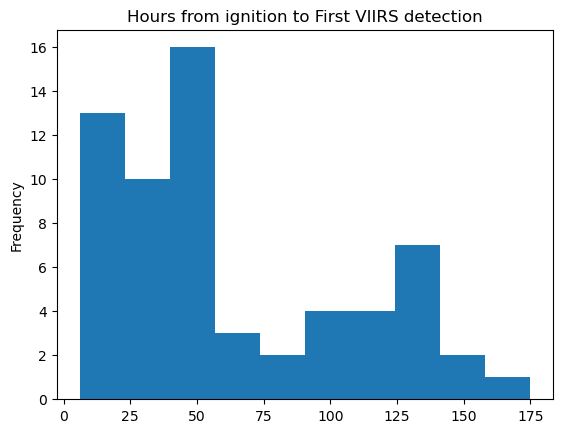

In [280]:
time_dist["time_diff"].astype('timedelta64[h]').plot.hist(title = "Hours from ignition to First VIIRS detection")
print(len(time_dist))
print(len(tmp_list))
print(len(time_dist)/len(tmp_list))

print(max_t)
print(min_t)
print(min(time_dist.time_diff))
print(max(time_dist.time_diff))
time_dist

In [46]:
# fr = fr.sort_values(by = ['t'])

# fig, ax = plt.subplots()
# ax.fill_between(upper.index, upper.FWI.rolling(1).mean(), lower.FWI.rolling(5).mean(), 
#                 facecolor='grey', 
#                 alpha=0.2,
#                 label= "95th Percentile")
# ax.fill_between(mid_upper.index, mid_upper.FWI.rolling(1).mean(), mid_lower.FWI.rolling(5).mean(), 
#                 facecolor='grey', 
#                 alpha=0.4,
#                 label= "25th Percentile")
# ax.plot(mean_quant.index, mean_quant.FWI.rolling(1).mean(), 
#         color = "black",
#         label= "Historic Mean Per Day")
# ax.plot(st[(st.time >= "2023-05-01")].time.astype('datetime64[ns]'), st[(st.time >= "2023-05-01")].FWI)
# ax.set_ylabel("Fire Weather Index")
# ax.set_title("2023 Fire Weather Index (FWI) for La Grande Rivière, Quebec, Canada (WMO ID 718270)")
# #ax.legend()
# ax2 = ax.twinx()
# ax2.scatter(candidate.t_left.astype("datetime64[ns]"), candidate.candidate, color = "purple")
# ax2.set_yticklabels("")
# #ax2.plot(fire_stats.t, fire_stats.num_active_fires, color = "red", label = "Number of Fires in Quebec")
# #ax2.legend(loc = 0.5)
# ax3 = ax.twinx()
# #ax3.spines.right.set_position(("axes", 1.2))
# ax3.plot(fr.t.astype("datetime64[ns]"), fr.farea, color = "red")
# #ax3.plot(day_strike.index.astype("datetime64[ns]"), day_strike.InterCloud, color = "orange")

# ax4 = ax.twinx()
# ax4.spines.right.set_position(("axes", 1.2))
# ax4.scatter(raw_obs_times.index, raw_obs_times['count'], color = "orange")

# fig.autofmt_xdate()

# # print("First detection: " + str(fr.t.astype("datetime64[ns]").min()) )
# print(candidate.t_left.min())
# print(candidate.t_left.max())

In [85]:
# def gpd_read_file(filename, parquet=False, **kwargs):
#     itry = 0
#     maxtries = 5
#     fun = gpd.read_parquet if parquet else gpd.read_file
#     while itry < maxtries:
#         try:
#             dat = fun(filename, **kwargs)
#             return dat
#         except Exception as e:
#             itry += 1
#             print(f"Attempt {itry}/{maxtries} failed.")
#             if not itry < maxtries:
#                 raise e



# def load_large_fire(fireID, year = "2019", path_region = "WesternUS", layer='perimeter', s3_path = False):
#     '''
#     loads in largefire file based on fireID and layer, then preps it for "explore" by adding centriod data. Currently limited to one year. 
    
#     INPUTS:
        
#         fireID (str): fireID offire of interest. Can be found in gdf files read in by prep_gdf and load_file. Can be selected interactivly form a gdf if use gdf.explore()
#         year (str): Year that fires took place. Default to 2019. Availible options differ by path_region. 
#         path_region (str): This constructs the path that the fires are stored in. WesternUS and CONUS availible. 
#         layer (str): The largefire layer to load. Options are 'perimeter', 'nfplist', 'fireline', and 'newfirepix'. 
#     '''
#     if(s3_path == True):
#         tmp = s3.glob('s3://maap-ops-workspace/shared/gsfc_landslides/FEDSoutput-s3-conus/' + path_region +'/'+ year +'/Largefire/F' + fireID + '_*')
#         lf_files =  ["s3://" + t for t in tmp]
    
#     else:
#         lf_files = glob.glob('/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/' + path_region +'/'+ year +'/Largefire/F' + fireID + '_*')
#         #print(lf_files)
#     lf_ids = list(set([file.split('Largefire/')[1].split('_')[0] for file in lf_files])) 
#     print(lf_ids)
#     largefire_dict = dict.fromkeys(lf_ids)
    
#     for lf_id in lf_ids:
#         most_recent_file = [file for file in lf_files if lf_id in file][-1]
#         largefire_dict[lf_id] = most_recent_file
#     if(s3_path == True):
#         gdf = pd.concat([gpd_read_file(file,layer= layer) for key, file in largefire_dict.items()], 
#                        ignore_index=True)
#     else:
#         gdf = pd.concat([gpd.read_file(file,layer= layer) for key, file in largefire_dict.items()], 
#                        ignore_index=True)
#     gdf = gdf.to_crs('EPSG:4326')
#     gdf['lon'] = gdf.centroid.x
#     gdf['lat'] = gdf.centroid.y
#     return gdf

In [ ]:
# load_large_fire(fireID = '13165', year = '2023', path_region= "BOREAL_NRT_3571_DPS", s3_path = True)

In [ ]:
# fireID = '13165'

# s3.glob('s3://maap-ops-workspace/shared/gsfc_landslides/FEDSoutput-s3-conus/' + path_region +'/'+ year +'/Largefire/F' + fireID + '_*')

In [ ]:
# tmp = s3.glob('s3://maap-ops-workspace/shared/gsfc_landslides/FEDSoutput-s3-conus/' + path_region +'/'+ year +'/Largefire/F' + fireID + '_*')

# tmp =  ["s3://" + t for t in tmp]

# tmp

In [ ]:
# fires[["fireID", 't', 'InterCloud', 'num_candidates']][fires.InterCloud.isna()]#.groupby(["fireID", 'InterCloud', 'num_candidates']).t.min()

In [150]:
fires.columns

Index(['Unnamed: 0', 'InterCloud', 'lat', 'lon', 'current_mag', 'error_elps',
       'num_station', 'num_candidates', 'num_strikes', 'num_strikes_10_days',
       'no_strikes', 't', 'viirs_pix_count', 'fireID', 'n_pixels',
       'n_newpixels', 'farea', 'fperim', 'flinelen', 'duration', 'pixden',
       'meanFRP', 'geometry', 'lon_centroid', 'lat_centroid', 'TEMP_C',
       'RH_PERC', 'VPD_HPA', 'WDSPD_KPH', 'PREC_MM', 'SNOWD_M', 'VIS_KM',
       'FFMC', 'DMC', 'DC', 'BUI', 'ISI', 'FWI', 'OBSMINUTEDIFF_TEMP',
       'OBSMINUTEDIFF_RH', 'OBSMINUTEDIFF_WDSPD', 'ISPRECREPORTED',
       'OBSMINUTEDIFF_SNOW', 'OBSMINUTEDIFF_VIS', 'pre_fire',
       'InterCloud_new_labs'],
      dtype='object')

In [281]:
min([np.nan, 0.0])

nan

In [282]:
fires["InterCloud_new_labs"] = fires.InterCloud
fires.loc[fires.InterCloud.isnull(),"InterCloud_new_labs"] = -1
has_lt = fires.groupby("fireID").InterCloud_new_labs.max().reset_index()
has_lt



fireID  InterCloud_new_labs
0    10013                 -1.0
1    10054                 -1.0
2    10056                 -1.0
3    10069                 -1.0
4    10140                 -1.0
..     ...                  ...
209   9612                  0.0
210   9791                  0.0
211   9837                 -1.0
212   9843                 -1.0
213   9844                 -1.0

[214 rows x 2 columns]

In [283]:


print(len(has_lt[has_lt.InterCloud_new_labs == -1]))

print(len(has_lt[has_lt.InterCloud_new_labs == 0]))


152
62


In [284]:
no_lt_ids = has_lt[has_lt.InterCloud_new_labs == -1].fireID.unique()
no_lt_ids

array(['10013', '10054', '10056', '10069', '10140', '10286', '10373',
       '10406', '10435', '10481', '10511', '10516', '10522', '10537',
       '10538', '10546', '10547', '10577', '10580', '10713', '10714',
       '10718', '10729', '10737', '10749', '10750', '10789', '10792',
       '10797', '10806', '10809', '10872', '10887', '10891', '10896',
       '10946', '10976', '10978', '11069', '11084', '11141', '11180',
       '11208', '11221', '11265', '11713', '12118', '12138', '12144',
       '12145', '12146', '12147', '12149', '12150', '12151', '12153',
       '12154', '12155', '12156', '12160', '12164', '12165', '12197',
       '12199', '12200', '12201', '12202', '12207', '12212', '12276',
       '12325', '12327', '12330', '12381', '12385', '12596', '12639',
       '12642', '12687', '12691', '12692', '12756', '13140', '13165',
       '13269', '13395', '13668', '13906', '14653', '8244', '8474',
       '8495', '8501', '8502', '8505', '8534', '8536', '8538', '8551',
       '8552', '8553'

In [285]:
# m = fire_timeline('10054', lt = lt, year = year, path_region= path_region, check_last = True, FWI_source = FWI_source)
# m2 = fire_timeline('10056', lt = lt, year = year, path_region= path_region, check_last = True, FWI_source = FWI_source)
# # for i in no_lt_ids:
    
#     m2 = fire_timeline(i, lt = lt, year = year, path_region= path_region, check_last = True, FWI_source = FWI_source)
#     m = m + m2

# m



In [286]:
fires.columns

Index(['fireID', 't', 'geometry', 'Unnamed: 0', 'InterCloud', 'lat', 'lon',
       'current_mag', 'error_elps', 'num_station', 'num_candidates',
       'num_strikes', 'num_strikes_10_days', 'no_strikes', 'viirs_pix_count',
       'n_pixels', 'n_newpixels', 'farea', 'fperim', 'flinelen', 'duration',
       'pixden', 'meanFRP', 'csv_geometry', 'lon_centroid', 'lat_centroid',
       'TEMP_C', 'RH_PERC', 'VPD_HPA', 'WDSPD_KPH', 'PREC_MM', 'SNOWD_M',
       'VIS_KM', 'FFMC', 'DMC', 'DC', 'BUI', 'ISI', 'FWI',
       'OBSMINUTEDIFF_TEMP', 'OBSMINUTEDIFF_RH', 'OBSMINUTEDIFF_WDSPD',
       'ISPRECREPORTED', 'OBSMINUTEDIFF_SNOW', 'OBSMINUTEDIFF_VIS', 'pre_fire',
       'InterCloud_new_labs'],
      dtype='object')

In [114]:

#from shapely import wkt


#fires[~fires.geometry.isna()].geometry = fires[~fires.geometry.isna()].geometry.astype("str").apply(wkt.loads)
gpd_fires = fires #gpd.GeoDataFrame(fires)
gpd_fires
#gpd_fires.set_crs("3571")

field_1 InterCloud lat lon current_mag error_elps num_station  \
0            0                                                         
1            1                                                         
2            2                                                         
3            3                                                         
4            4                                                         
...        ...        ...  ..  ..         ...        ...         ...   
149365    1006                                                         
149366    1007                                                         
149367    1008                                                         
149368    1009                                                         
149369    1010                                                         

       num_candidates num_strikes num_strikes_10_days  ...               ISI  \
0                                                      ...                     
1                                                      ...                     
2                                                      ...                     
3                                                      ...                     
4                                                      ...                     
...               ...         ...                 ...  ...               ...   
149365                                                 ...  9.37652293342066   
149366                                                 ...  7.12476274785227   
149367                                                 ...  5.75897023960651   
149368                                                 ...  4.47346450208124   
149369                                                 ...  4.20287611062312   

                     FWI OBSMINUTEDIFF_TEMP OBSMINUTEDIFF_RH  \
0                                                              
1                                                              
2                                                              
3                                                              
4                                                              
...                  ...                ...              ...   
149365  35.2101098017338                0.0              0.0   
149366  29.3019533508246                0.0              0.0   
149367  25.3172610311877                0.0              0.0   
149368  21.1822773207792                0.0              0.0   
149369  20.2517431125646                0.0              0.0   

       OBSMINUTEDIFF_WDSPD ISPRECREPORTED OBSMINUTEDIFF_SNOW  \
0                                                              
1                                                              
2                                                              
3                                                              
4                                                              
...                    ...            ...                ...   
149365                 0.0            1.0                0.0   
149366                 0.0            1.0                0.0   
149367                 0.0            1.0                0.0   
149368                 0.0            1.0                0.0   
149369                 0.0            1.0                0.0   

       OBSMINUTEDIFF_VIS pre_fire geometry  
0                           False     None  
1                           False     None  
2                           False     None  
3                           False     None  
4                           False     None  
...                  ...      ...      ...  
149365               0.0    False     None  
149366               0.0    False     None  
149367               0.0    False     None  
149368               0.0    False     None  
149369               0.0    False     None  

[149370 rows x 45 columns]

In [116]:
#gpd_fires[gpd_fires.num_candidates > 0]

In [287]:
gpd_fires.t = gpd_fires.t.astype("str")

In [288]:
#from shapely import wkt


#fires['geometry'] =fires['geometry'].apply(wkt.loads)

#gpd_fires = gpd.GeoDataFrame(fires, crs = "3571", geometry  = 'geometry')
gpd_fires = gpd_fires.set_crs(crs = "3571")

In [ ]:
#gpd_fires[~gpd_fires.geometry.isna()].explore(column = "InterCloud", style_kwds = {"fillOpacity": "0.1"} )

In [353]:
#no_null_geoms =

first_perims = gpd_fires[~gpd_fires.geometry.isnull()].groupby("fireID").t.min().reset_index()
first_perims

last_perims = gpd_fires[~gpd_fires.geometry.isnull()].groupby("fireID").t.max().reset_index()
last_perims

print(type(gpd_fires))
mask = gpd_fires.geometry.isna()
trouble = gpd_fires[~(mask)]
#plot_last = gpd_fires[~gpd_fires.geometry.isnull()].merge(last_perims, on = ["fireID", "t"], how = 'right')
#plot_last = last_perims.merge(gpd_fires[~gpd_fires.geometry.isnull()], on = ["fireID", "t"], how = 'left')
#gpd_fires = gpd_fires.set_geometry("geometry")
plot_last = fires.merge(last_perims, on = ["fireID", "t"], how = 'right')
plot_first = fires.merge(first_perims, on = ["fireID", "t"], how = 'right')
#plot_last = fires.merge(first_perims, on = ["fireID", "t"], how = 'right')
plot_last = plot_last.merge(plot_first[["fireID", "t", "geometry", "InterCloud"]], on = ["fireID", "t", "geometry", "InterCloud"], how = 'outer')
plot_last = plot_last.sort_values(by = "fireID", ascending= True)
plot_last[["fireID", "t", "geometry", "InterCloud"]]
plot_last.InterCloud.unique()

<class 'geopandas.geodataframe.GeoDataFrame'>


array([nan])

In [355]:
# print(type(trouble))
# print(type(gpd_fires[~gpd_fires.geometry.isnull()]))
# print(type(plot_last))

has_lt = fires.groupby("fireID").InterCloud.max().reset_index()


has_lt["has_lt"] = ~(has_lt.InterCloud.isnull())

In [356]:
has_lt[has_lt.has_lt]

fireID  InterCloud  has_lt
5    10147         0.0    True
32   10843         0.0    True
38   10972         0.0    True
48   11302         0.0    True
49   11355         0.0    True
..     ...         ...     ...
202   9203         0.0    True
207   9346         0.0    True
208   9509         0.0    True
209   9612         0.0    True
210   9791         0.0    True

[62 rows x 3 columns]

In [357]:
print(has_lt["has_lt"].unique())

plot_last = plot_last.merge(has_lt, on = ["fireID"], how = "left")

[False  True]


In [358]:
#plot_last = gpd.GeoDataFrame(plot_last)
print(type(plot_last))
plot_last.columns

<class 'geopandas.geodataframe.GeoDataFrame'>


Index(['fireID', 't', 'geometry', 'Unnamed: 0', 'InterCloud_x', 'lat', 'lon',
       'current_mag', 'error_elps', 'num_station', 'num_candidates',
       'num_strikes', 'num_strikes_10_days', 'no_strikes', 'viirs_pix_count',
       'n_pixels', 'n_newpixels', 'farea', 'fperim', 'flinelen', 'duration',
       'pixden', 'meanFRP', 'csv_geometry', 'lon_centroid', 'lat_centroid',
       'TEMP_C', 'RH_PERC', 'VPD_HPA', 'WDSPD_KPH', 'PREC_MM', 'SNOWD_M',
       'VIS_KM', 'FFMC', 'DMC', 'DC', 'BUI', 'ISI', 'FWI',
       'OBSMINUTEDIFF_TEMP', 'OBSMINUTEDIFF_RH', 'OBSMINUTEDIFF_WDSPD',
       'ISPRECREPORTED', 'OBSMINUTEDIFF_SNOW', 'OBSMINUTEDIFF_VIS', 'pre_fire',
       'InterCloud_new_labs', 'InterCloud_y', 'has_lt'],
      dtype='object')

In [359]:
# plot_last[['fireID', 't', 'has_lt', 'n_pixels', 'n_newpixels',
#        'farea', 'fperim', 'flinelen', 'duration', 'pixden', 'meanFRP',
#        'geometry', 'lon_centroid', 'lat_centroid', ]].explore(column = "has_lt", cmap = "Set1")

#plot_last[~plot_last.geometry.isnull()].explore(column = "has_lt", cmap = "Set1")

plot_last_tmp = plot_last[~plot_last.geometry.isnull()]
#plot_last_tmp.geometry


#from shapely import wkt


#plot_last_tmp['geometry'] = plot_last_tmp['geometry'].apply(wkt.loads)

plot_last_tmp = gpd.GeoDataFrame(plot_last_tmp, crs = "3571", geometry  = 'geometry')
type(plot_last_tmp)

# print(plot_last_tmp.InterCloud.unique())
# print(len(plot_last_tmp[plot_last_tmp.InterCloud == '']))
# print(len(plot_last_tmp[plot_last_tmp.InterCloud.isnull()]))

geopandas.geodataframe.GeoDataFrame

In [360]:
fires[fires.fireID == "8495"]

fireID                    t geometry  Unnamed: 0  InterCloud  lat  lon  \
44362   8495  2023-06-01 07:46:00     None           0         NaN  NaN  NaN   
44363   8495  2023-06-01 16:43:00     None           1         NaN  NaN  NaN   
44364   8495  2023-06-01 17:34:00     None           2         NaN  NaN  NaN   
44365   8495  2023-06-01 18:24:00     None           3         NaN  NaN  NaN   
44366   8495  2023-06-02 05:46:00     None           4         NaN  NaN  NaN   
...      ...                  ...      ...         ...         ...  ...  ...   
46203   8495  2023-07-23 19:00:00     None        1841         NaN  NaN  NaN   
46204   8495  2023-07-23 20:00:00     None        1842         NaN  NaN  NaN   
46205   8495  2023-07-23 21:00:00     None        1843         NaN  NaN  NaN   
46206   8495  2023-07-23 22:00:00     None        1844         NaN  NaN  NaN   
46207   8495  2023-07-23 23:00:00     None        1845         NaN  NaN  NaN   

       current_mag  error_elps  num_station  ...       ISI        FWI  \
44362          NaN         NaN          NaN  ...       NaN        NaN   
44363          NaN         NaN          NaN  ...       NaN        NaN   
44364          NaN         NaN          NaN  ...       NaN        NaN   
44365          NaN         NaN          NaN  ...       NaN        NaN   
44366          NaN         NaN          NaN  ...       NaN        NaN   
...            ...         ...          ...  ...       ...        ...   
46203          NaN         NaN          NaN  ...  7.186825  31.442279   
46204          NaN         NaN          NaN  ...  5.115795  24.921547   
46205          NaN         NaN          NaN  ...  4.784759  23.781613   
46206          NaN         NaN          NaN  ...  4.530988  22.885225   
46207          NaN         NaN          NaN  ...  4.335354  22.179849   

       OBSMINUTEDIFF_TEMP OBSMINUTEDIFF_RH  OBSMINUTEDIFF_WDSPD  \
44362                 NaN              NaN                  NaN   
44363                 NaN              NaN                  NaN   
44364                 NaN              NaN                  NaN   
44365                 NaN              NaN                  NaN   
44366                 NaN              NaN                  NaN   
...                   ...              ...                  ...   
46203                 0.0              0.0                  0.0   
46204                 0.0              0.0                  0.0   
46205               720.0            720.0                720.0   
46206               660.0            660.0                660.0   
46207               600.0            600.0                600.0   

       ISPRECREPORTED  OBSMINUTEDIFF_SNOW  OBSMINUTEDIFF_VIS  pre_fire  \
44362             NaN                 NaN                NaN     False   
44363             NaN                 NaN                NaN     False   
44364             NaN                 NaN                NaN     False   
44365             NaN                 NaN                NaN     False   
44366             NaN                 NaN                NaN     False   
...               ...                 ...                ...       ...   
46203             0.0                 0.0                0.0     False   
46204             0.0                 0.0                0.0     False   
46205             0.0               720.0              720.0     False   
46206             0.0               660.0              660.0     False   
46207             0.0               600.0              600.0     False   

       InterCloud_new_labs  
44362                 -1.0  
44363                 -1.0  
44364                 -1.0  
44365                 -1.0  
44366                 -1.0  
...                    ...  
46203                 -1.0  
46204                 -1.0  
46205                 -1.0  
46206                 -1.0  
46207                 -1.0  

[1846 rows x 47 columns]

In [371]:
plot_last_tmp[['t', 'viirs_pix_count', 'fireID', 'n_pixels',
       'n_newpixels', 'farea', 'fperim', 'flinelen', 'duration', 'pixden',
       'meanFRP', 'geometry', 'has_lt']].explore(column = "has_lt", cmap = "Set1")

In [373]:
plot_last_tmp[plot_last_tmp.fireID == '10373'][['t', 'viirs_pix_count', 'fireID', 'n_pixels',
       'n_newpixels', 'farea', 'fperim', 'flinelen', 'duration', 'pixden',
       'meanFRP', 'geometry', 'has_lt']].explore(column = "has_lt", cmap = "Set1")

In [362]:
### Check how many "non lightning ignited fires" have a spatial intersection with a "lightning ignited fire"

lt_true = plot_last_tmp[plot_last_tmp.has_lt == True]
lt_false = plot_last_tmp[plot_last_tmp.has_lt == False]

lt_test = lt_false.sjoin(lt_true)
lt_test[['fireID_left', 't_left', 'geometry', 
         
       'fireID_right', 't_right',  'has_lt_right']]

fireID_left                   t_left  \
14        10373  2023-06-16 12:00:00.000   
15        10373  2023-06-18 00:00:00.000   
30        10538      2023-06-25 12:00:00   
298        8619  2023-07-24 00:00:00.000   
30        10538      2023-06-25 12:00:00   
..          ...                      ...   
324        8639      2023-07-16 12:00:00   
324        8639      2023-07-16 12:00:00   
324        8639      2023-07-16 12:00:00   
387        9188      2023-07-16 12:00:00   
387        9188      2023-07-16 12:00:00   

                                              geometry fireID_right  \
14   POLYGON ((4158852.818 1019497.274, 4158854.897...         9791   
15   POLYGON ((4158858.906 1019535.029, 4158864.804...         9791   
30   POLYGON ((4162410.512 1108954.580, 4162409.545...        10147   
298  MULTIPOLYGON (((4171100.751 1177472.220, 41710...        10147   
30   POLYGON ((4162410.512 1108954.580, 4162409.545...        10147   
..                                                 ...          ...   
324  MULTIPOLYGON (((4295291.110 1150222.364, 42952...         9203   
324  MULTIPOLYGON (((4295291.110 1150222.364, 42952...         9200   
324  MULTIPOLYGON (((4295291.110 1150222.364, 42952...         9200   
387  MULTIPOLYGON (((4112110.174 1252191.244, 41120...         9509   
387  MULTIPOLYGON (((4112110.174 1252191.244, 41120...         9509   

                     t_right  has_lt_right  
14   2023-07-24 00:00:00.000          True  
15   2023-07-24 00:00:00.000          True  
30   2023-06-13 12:00:00.000          True  
298  2023-06-13 12:00:00.000          True  
30   2023-07-03 12:00:00.000          True  
..                       ...           ...  
324  2023-06-27 00:00:00.000          True  
324  2023-06-12 00:00:00.000          True  
324  2023-06-06 00:00:00.000          True  
387  2023-06-13 00:00:00.000          True  
387  2023-06-08 00:00:00.000          True  

[82 rows x 6 columns]

There are  30  ignition-less fire perimeters that overlap with a lightning ignition
out of  152 total ignition-less fires
when there are  62  fires with confirmed strikes
37 days 12:00:00
-52 days +12:00:00
There are  16 fires where strikes happened before


10.730769230769232

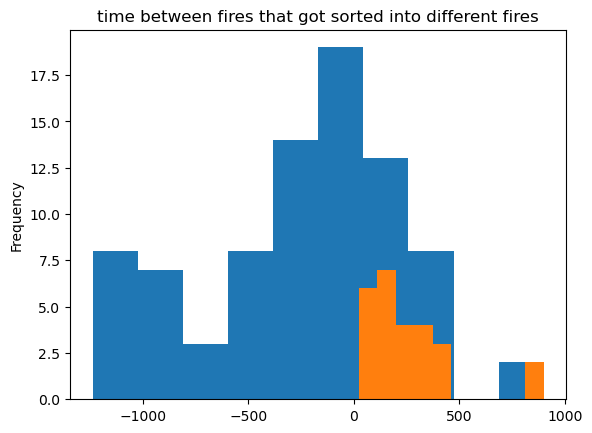

In [383]:
print("There are ", len(lt_test.fireID_left.unique()), " ignition-less fire perimeters that overlap with a lightning ignition")
print("out of ", len(lt_false.fireID.unique()),  "total ignition-less fires")

print("when there are ", len(lt_true.fireID.unique()),  " fires with confirmed strikes")


## Check difference bewtween big fires

lt_test["t_diff"] = lt_test.t_right.astype("datetime64[ns]") - lt_test.t_left.astype("datetime64[ns]")


lt_test["t_diff"].astype('timedelta64[h]').plot.hist(title = "time between fires that got sorted into different fires")

print(lt_test["t_diff"].max())
print(lt_test["t_diff"].min())

lt_test[lt_test["t_diff"] == lt_test["t_diff"].max()].fireID_left

print("There are ", len(lt_test[lt_test["t_diff"].astype("int") > 0].fireID_left.unique()), "fires where strikes happened before")


lt_test[lt_test["t_diff"].astype("int") > 0].t_diff.astype('timedelta64[h]').plot.hist(title = "time between fires that got sorted into different fires")
lt_test[lt_test["t_diff"].astype("int") > 0].t_diff.astype('timedelta64[h]').mean()/24

In [312]:
# gpd_fires

In [310]:
# first_perims = gpd_fires[~gpd_fires.geometry.isnull()].groupby("fireID").t.min()
# first_perims

# last_perims = gpd_fires[~gpd_fires.geometry.isnull()].groupby("fireID").t.max().reset_index()
# last_perims

# plot_last = last_perims.merge(gpd_fires[~gpd_fires.geometry.isnull()], on = ["fireID", "t"], how = "left")

In [311]:
# no_lt_ids

In [73]:
# year = '2023'
# fireID = '12146'
# check_last = False
# path_region="BOREAL_NRT_3571_DPS"  
# check_last = False 
# FWI_source = "station"

# ## Read in the largefire file of the fireID
# try:
#     fr = fv.load_large_fire(fireID, year = year, path_region= path_region, s3_path = True) ## Cluster of 2 fires. 
# except Exception as e:
#     print("Fire ID cannot be opened:",fireID)
#     print(e)

#     ## TO DO Filter? 
#         ## VIIRS Static source filter?
#         ## WUI filter? 

# fr = fr.to_crs("3571")
# oldest_perim = fr[fr.t == fr.t.max()]
# first_perim = fr[fr.t == fr.t.min()]

# if(check_last == True):
#     oldest_perim.t = oldest_perim.t.astype("str")
#     m = oldest_perim.explore()





#  ## Subset lightning by time and space

# ## TO DO: Figure out which CA ecoregion/province the fire is in and subset lighting by that? 
# #print("Not yet subseting spatially beyond quebec. Assuming quebec bounding box")

# min_threshold = fr.t.astype('datetime64[ns]').min() - timedelta(days = 10)
# possible_lt = lt[lt.t <= fr.t.min()]
# possible_lt = possible_lt[possible_lt.t >= min_threshold]

# #first_perim.geometry = first_perim.buffer(750*2) ## Two viirs pixels???
# join_lt = gpd.sjoin(possible_lt, first_perim, predicate = 'within', how = "inner")
# join_lt["no_strikes_in_time"] = False

# if (len(possible_lt == 0)):
#     join_lt["no_strikes_in_time"] = True

# if (len(join_lt[join_lt.InterCloud.isna()].InterCloud) == len(join_lt.InterCloud)):
#     join_lt["num_candidates"] = 0
#     join_lt["num_strikes"] = len(possible_lt)
#     join_lt["num_strikes_10_days"] = len(possible_lt)
# else:
#     ## Extract "denominator" or the # of strikes from same period
#     denominator = possible_lt[possible_lt.t >= join_lt.t_left.min()]
#     denominator = denominator[denominator.t <= join_lt.t_left.max()]
#     join_lt["num_candidates"] = len(join_lt)
#     join_lt["num_strikes"] = len(denominator)
#     join_lt["num_strikes_10_days"] = len(possible_lt)

# ## Get distance to individuals ignitions
# # fr["perim_rank"] = fr.t.rank()
# # first_geom = fr[fr.perim_rank == 1].geometry
# # first_geom = first_geom.iloc[0]
# # num_starts = len(first_geom.geoms)
# # for i in range(0, num_starts):
# #     join_lt["dist_start_" + str(i)] = join_lt.distance(first_geom.geoms[i].centroid)
# #     print(fr[fr.perim_rank == 1].to_crs("4326").geometry.iloc[0].geoms[i].centroid)

# ## Rank candidate by distance
# # range_geoms = list(range(0, num_starts))
# # string = "dist_start_"
# # columns_dists = [string + str(x) for x in range_geoms]
# # top = len(join_lt) * 1 # Top 100%. Could cut to smaller range
# # dist_bool = join_lt[columns_dists].rank() <= top ## NEED a max distance cutoff. 
# # join_lt["candidate"] = dist_bool.any(axis = 1)

# ## Get raw VIIRS pixel timing
# date_string = fr.t.astype("datetime64[ns]").max().strftime("%Y%m%d%p")
# print(date_string)
# raw_obs_times = fv.raw_pixel_times(int(fireID), date_string = date_string, path_region = path_region)
# raw_obs_times = raw_obs_times.reset_index()

# ## get station data
# if(FWI_source == "station"):
#     print("Assuming Single Quebec Station. 718270-99999.")
#     st = pd.read_csv("s3://veda-data-store-staging/EIS/other/station-FWI/19900101.NRT/FWI/718270-99999.linear.HourlyFWIFromHourlyInterpContinuous.csv") ## Corrected record from Robert
#     st.HH = st.HH.astype("int")
#     st.YYYY = st.YYYY.astype("int")
#     st.MM = st.MM.astype("int")
#     st.DD = st.DD.astype("int")
#     st = fv.date_convert(st)

#     st_rm = st[["time", "TEMP_C", 'RH_PERC', 'VPD_HPA', 'WDSPD_KPH',
#    'PREC_MM', 'SNOWD_M', 'VIS_KM', 'FFMC', 'DMC', 'DC', 'BUI', 'ISI',
#    'FWI', 'OBSMINUTEDIFF_TEMP', 'OBSMINUTEDIFF_RH', 'OBSMINUTEDIFF_WDSPD',
#    'ISPRECREPORTED', 'OBSMINUTEDIFF_SNOW', 'OBSMINUTEDIFF_VIS']]
#     st_rm = st_rm.rename(columns = {"time":"t"})
#     #### Subset station data by time. 
#     st_rm = st_rm[st_rm.t >= min_threshold]
#     st_rm = st_rm[st_rm.t <= fr.t.max()]

# else:
#     #print("No other FWI extraction method ready. Sorry. ")
#     raise Exception("No other FWI extraction method ready. Sorry. ")

# ## Do merging of all dfs 
# foo = join_lt[["InterCloud", "t_left", "lat_left", "lon_left", "current_mag", "error_elps", "num_station", "num_candidates", "num_strikes", "num_strikes_10_days", "no_strikes_in_time"]]
# foo = foo.rename(columns = {"t_left":"t", "lat_left":"lat", "lon_left":"lon"})
# foo.t = foo.t.astype('datetime64[ns]')
# raw_obs_times = raw_obs_times.rename(columns={"count": "viirs_pix_count"}) 
# raw_obs_times.t = raw_obs_times.t.astype("datetime64[ns]")
# merged = foo.merge(raw_obs_times, on = ["t"], how = "outer")

# fr_rm = fr.rename(columns = {"lat":"lat_centroid", "lon":"lon_centroid"})
# fr_rm.t = fr_rm.t.astype("datetime64[ns]")
# merged = merged.merge(fr_rm, on = ["t"], how = "outer")

# merged = merged.merge(st_rm, on = ["t"], how = "outer")
# merged["fireID"] = fireID

# ## Find temporal thresholds

# first_ig = merged[~merged.InterCloud.isna()].t.min()
# last_ig = merged[~merged.InterCloud.isna()].t.max()
# first_detection = merged[~merged.viirs_pix_count.isna()].t.min()


# merged["pre_fire"] = ((merged.t >= last_ig) & (merged.t <=  first_detection)) #### first_ig better????????????

['F12146']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:594: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:595: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y


20230729PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:930: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  data = pickle.load(file)


Assuming Single Quebec Station. 718270-99999.


In [76]:
# #possible_lt
# join_lt

Empty GeoDataFrame
Columns: [InterCloud, t_left, lat_left, lon_left, current_mag, multiplicity_0, accr, error_elps, num_station, geometry, index_right, n_pixels, n_newpixels, farea, fperim, flinelen, duration, pixden, meanFRP, t_right, lon_right, lat_right, no_strikes_in_time, num_candidates, num_strikes, num_strikes_10_days]
Index: []

[0 rows x 26 columns]

In [308]:
# first_perim.t = first_perim.t.astype("str")
# first_perim.explore()

In [309]:
# first_perim.buffer(750*2).explore() ## Two viirs pixels???

# #first_perim.crs

In [53]:
lt.crs

<Derived Projected CRS: EPSG:3571>
Name: WGS 84 / North Pole LAEA Bering Sea
Axis Info [cartesian]:
- X[south]: Easting (metre)
- Y[south]: Northing (metre)
Area of Use:
- name: Northern hemisphere - north of 45°N, including Arctic.
- bounds: (-180.0, 45.0, 180.0, 90.0)
Coordinate Operation:
- name: North Pole Lambert Azimuthal Equal Area (Bering Sea)
- method: Lambert Azimuthal Equal Area
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich